# Apache log analysis using Apache Spark

In [1]:
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
# Code for setting up matplotlib
#set default plot characterstics and colors
from matplotlib import rcParams
dark_colors = ["#99D699", "#B2B2B2",
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]
rcParams['figure.figsize'] = (12, 9)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = "white"
rcParams['axes.titlesize'] = 20      
rcParams['axes.labelsize'] = 17.5
rcParams['xtick.labelsize'] = 15 
rcParams['ytick.labelsize'] = 15
rcParams['legend.fontsize'] = 17.5
rcParams['patch.edgecolor'] = 'none'
rcParams['grid.color']="white"   
rcParams['grid.linestyle']="-" 
rcParams['grid.linewidth'] = 1
rcParams['grid.alpha']=1
rcParams['text.color'] = "444444"
rcParams['axes.labelcolor'] = "444444"
rcParams['ytick.color'] = "444444"
rcParams['xtick.color'] = "444444"

In [3]:
import findspark
findspark.init() 

import pyspark
sc = pyspark.SparkContext()

In [4]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

### Some boilerplate code for reading the data

In [3]:
# A regular expression pattern to extract fields from the log line
APACHE_ACCESS_LOG_PATTERN = '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+) (\S+)\s*(\S*)" (\d{3}) (\S+)'

In [5]:
import re
import datetime
from pyspark.sql import Row

In [11]:
month_map = {'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
    'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12}


def parse_apache_time(s):
    """
    Takes a time string from Apache common log format and converts it into useful stuff..!
    """
    return datetime.datetime(int(s[7:11]),
                             month_map[s[3:6]],
                             int(s[0:2]),
                             int(s[12:14]),
                             int(s[15:17]),
                             int(s[18:20]))

In [12]:
def parseApacheLogLine(logline):
    match = re.search(APACHE_ACCESS_LOG_PATTERN, logline)
    # returning a tuple of line and zero if it's a failure
    if match is None:
        return (logline, 0)
    size_field = match.group(9)
    if size_field == '-':
        size = long(0)
    else:
        size = long(match.group(9))
    # returning a tuple of row and a feedback
    return (Row(
        host          = match.group(1),
        client_identd = match.group(2),
        user_id       = match.group(3),
        date_time     = parse_apache_time(match.group(4)),
        method        = match.group(5),
        endpoint      = match.group(6),
        protocol      = match.group(7),
        response_code = int(match.group(8)),
        content_size  = size
    ), 1)

In [8]:
logFile = 'access_log_Jul95'

# Python's strong indentation wouldn't allow empty spaces, so sc.Textfile is kept inside ()
parsed_ones = (sc.textFile(logFile)
                   .map(parseApacheLogLine)
                   .cache())
# Checking the correct ones
access_logs = (parsed_ones
                   .filter(lambda s: s[1] == 1)
                   .map(lambda s: s[0])
                   .cache())
# Checking the failed ones
failed_logs = (parsed_ones
                   .filter(lambda s: s[1] == 0)
                   .map(lambda s: s[0]))
failed_logs_count = failed_logs.count()
if failed_logs_count > 0:
    print 'Number of invalid logline: %d' % failed_logs.count()
    for line in failed_logs.take(20):
        print 'Invalid logline: %s' % line

print 'Read %d lines' % (parsed_ones.count())
print 'Successfully parsed %d lines' % (access_logs.count())
print 'Failed to parse %d lines' % (failed_logs_count)

Number of invalid logline: 864
Invalid logline: 204.120.229.63 - - [01/Jul/1995:04:29:05 -0400] "GET /history/history.html                                                 hqpao/hqpao_home.html HTTP/1.0" 200 1502
Invalid logline: nccse.gsfc.nasa.gov - - [01/Jul/1995:07:36:13 -0400] "GET /shuttle/missions/missions.html Shuttle Launches from Kennedy Space Center HTTP/1.0" 200 8677
Invalid logline: ix-nbw-nj1-22.ix.netcom.com - - [01/Jul/1995:10:42:09 -0400] "GET /finger @net.com HTTP/1.0" 404 -
Invalid logline: gpotterpc.llnl.gov - - [01/Jul/1995:22:26:51 -0400] "GET /htbin/wais.pl?orbit sts71 HTTP/1.0" 200 317
Invalid logline: wxs6-7.worldaccess.nl - - [02/Jul/1995:08:09:27 -0400] "GET / /   HTTP/1.0" 200 7074
Invalid logline: wxs6-7.worldaccess.nl - - [02/Jul/1995:08:11:20 -0400] "GET / /facts/facts.html HTTP/1.0" 200 7074
Invalid logline: s29.abqslip.indirect.com - - [02/Jul/1995:14:24:26 -0400] "GET /htbin/wais.pl?Wake Shield HTTP/1.0" 200 7020
Invalid logline: pipe3.nyc.pipeline.com 

In [9]:
for line in failed_logs.take(10):
    print line
#Spaces in the URL could be the reason for the failure of parsing.

204.120.229.63 - - [01/Jul/1995:04:29:05 -0400] "GET /history/history.html                                                 hqpao/hqpao_home.html HTTP/1.0" 200 1502
nccse.gsfc.nasa.gov - - [01/Jul/1995:07:36:13 -0400] "GET /shuttle/missions/missions.html Shuttle Launches from Kennedy Space Center HTTP/1.0" 200 8677
ix-nbw-nj1-22.ix.netcom.com - - [01/Jul/1995:10:42:09 -0400] "GET /finger @net.com HTTP/1.0" 404 -
gpotterpc.llnl.gov - - [01/Jul/1995:22:26:51 -0400] "GET /htbin/wais.pl?orbit sts71 HTTP/1.0" 200 317
wxs6-7.worldaccess.nl - - [02/Jul/1995:08:09:27 -0400] "GET / /   HTTP/1.0" 200 7074
wxs6-7.worldaccess.nl - - [02/Jul/1995:08:11:20 -0400] "GET / /facts/facts.html HTTP/1.0" 200 7074
s29.abqslip.indirect.com - - [02/Jul/1995:14:24:26 -0400] "GET /htbin/wais.pl?Wake Shield HTTP/1.0" 200 7020
pipe3.nyc.pipeline.com - - [02/Jul/1995:22:24:41 -0400] "GET /shuttle/countdown/dy �?shuttle%20tracking HTTP/1.0" 404 -
pipe3.nyc.pipeline.com - - [02/Jul/1995:22:25:48 -0400] "GET /shuttle/

In [13]:
# changed pattern 
APACHE_ACCESS_LOG_PATTERN = '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+) (\S+)\s*(\S*)\s*" (\d{3}) (\S+)'

In [14]:
logFile = 'access_log_Jul95'

# Python's strong indentation wouldn't allow empty spaces, so sc.Textfile is kept inside ()
parsed_ones = (sc.textFile(logFile)
                   .map(parseApacheLogLine)
                   .cache())
# Checking the correct ones
access_logs = (parsed_ones
                   .filter(lambda s: s[1] == 1)
                   .map(lambda s: s[0])
                   .cache())
# Checking the failed ones
failed_logs = (parsed_ones
                   .filter(lambda s: s[1] == 0)
                   .map(lambda s: s[0]))
failed_logs_count = failed_logs.count()
if failed_logs_count > 0:
    print 'Number of invalid logline: %d' % failed_logs.count()
    for line in failed_logs.take(20):
        print 'Invalid logline: %s' % line

print 'Read %d lines' % (parsed_ones.count())
print 'Successfully parsed %d lines' % (access_logs.count())
print 'Failed to parse %d lines' % (failed_logs_count)

Number of invalid logline: 849
Invalid logline: 204.120.229.63 - - [01/Jul/1995:04:29:05 -0400] "GET /history/history.html                                                 hqpao/hqpao_home.html HTTP/1.0" 200 1502
Invalid logline: nccse.gsfc.nasa.gov - - [01/Jul/1995:07:36:13 -0400] "GET /shuttle/missions/missions.html Shuttle Launches from Kennedy Space Center HTTP/1.0" 200 8677
Invalid logline: ix-nbw-nj1-22.ix.netcom.com - - [01/Jul/1995:10:42:09 -0400] "GET /finger @net.com HTTP/1.0" 404 -
Invalid logline: gpotterpc.llnl.gov - - [01/Jul/1995:22:26:51 -0400] "GET /htbin/wais.pl?orbit sts71 HTTP/1.0" 200 317
Invalid logline: wxs6-7.worldaccess.nl - - [02/Jul/1995:08:09:27 -0400] "GET / /   HTTP/1.0" 200 7074
Invalid logline: wxs6-7.worldaccess.nl - - [02/Jul/1995:08:11:20 -0400] "GET / /facts/facts.html HTTP/1.0" 200 7074
Invalid logline: s29.abqslip.indirect.com - - [02/Jul/1995:14:24:26 -0400] "GET /htbin/wais.pl?Wake Shield HTTP/1.0" 200 7020
Invalid logline: pipe3.nyc.pipeline.com 

### Converting Spark SQL to DataFrame

In [15]:
access_logs.take(5)

[Row(client_identd=u'-', content_size=6245L, date_time=datetime.datetime(1995, 7, 1, 0, 0, 1), endpoint=u'/history/apollo/', host=u'199.72.81.55', method=u'GET', protocol=u'HTTP/1.0', response_code=200, user_id=u'-'),
 Row(client_identd=u'-', content_size=3985L, date_time=datetime.datetime(1995, 7, 1, 0, 0, 6), endpoint=u'/shuttle/countdown/', host=u'unicomp6.unicomp.net', method=u'GET', protocol=u'HTTP/1.0', response_code=200, user_id=u'-'),
 Row(client_identd=u'-', content_size=4085L, date_time=datetime.datetime(1995, 7, 1, 0, 0, 9), endpoint=u'/shuttle/missions/sts-73/mission-sts-73.html', host=u'199.120.110.21', method=u'GET', protocol=u'HTTP/1.0', response_code=200, user_id=u'-'),
 Row(client_identd=u'-', content_size=0L, date_time=datetime.datetime(1995, 7, 1, 0, 0, 11), endpoint=u'/shuttle/countdown/liftoff.html', host=u'burger.letters.com', method=u'GET', protocol=u'HTTP/1.0', response_code=304, user_id=u'-'),
 Row(client_identd=u'-', content_size=4179L, date_time=datetime.date

We would ideally want to interact with data at a column level, so it is important to convert this data into a DataFrame like object. 

In [16]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [17]:
logsDF = sqlContext.createDataFrame(access_logs)

In [18]:
logsDF.show(5)

+-------------+------------+--------------------+--------------------+--------------------+------+--------+-------------+-------+
|client_identd|content_size|           date_time|            endpoint|                host|method|protocol|response_code|user_id|
+-------------+------------+--------------------+--------------------+--------------------+------+--------+-------------+-------+
|            -|        6245|1995-07-01 00:00:...|    /history/apollo/|        199.72.81.55|   GET|HTTP/1.0|          200|      -|
|            -|        3985|1995-07-01 00:00:...| /shuttle/countdown/|unicomp6.unicomp.net|   GET|HTTP/1.0|          200|      -|
|            -|        4085|1995-07-01 00:00:...|/shuttle/missions...|      199.120.110.21|   GET|HTTP/1.0|          200|      -|
|            -|           0|1995-07-01 00:00:...|/shuttle/countdow...|  burger.letters.com|   GET|HTTP/1.0|          304|      -|
|            -|        4179|1995-07-01 00:00:...|/shuttle/missions...|      199.120.110.21

In [19]:
logsDF.printSchema()

root
 |-- client_identd: string (nullable = true)
 |-- content_size: long (nullable = true)
 |-- date_time: timestamp (nullable = true)
 |-- endpoint: string (nullable = true)
 |-- host: string (nullable = true)
 |-- method: string (nullable = true)
 |-- protocol: string (nullable = true)
 |-- response_code: long (nullable = true)
 |-- user_id: string (nullable = true)



We will save the DataFrame to disk, so that we don't have to parse again. The Spark UI looks like this at this moment.

In [20]:
logsDF.write.parquet('logs_DataFrame')

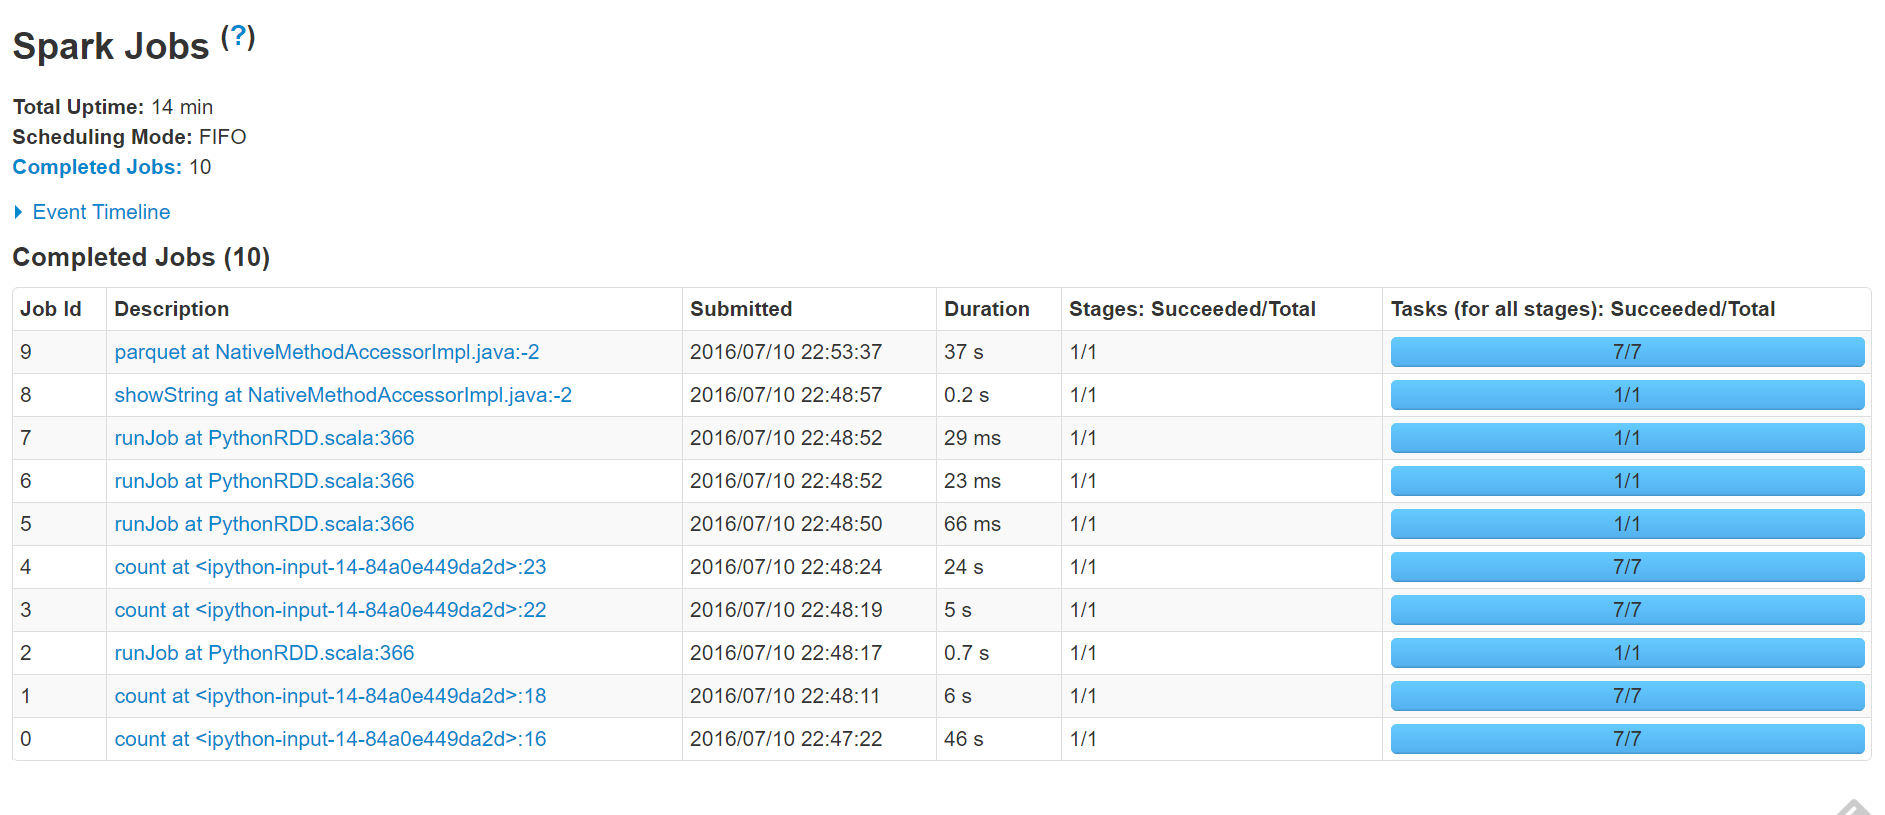

In [22]:
Image('images/Spark_UI.PNG')

### Exploratory data analysis

#### Response code distribution

In [17]:
response_logs = logsDF.groupBy('response_code').count()
# This is lazily evaluated upto the count method, it returns a Spark dataframe
# Converting it into a Pandas dataframe using toPandas()

In [18]:
response_df = response_logs.toPandas()
# RDD dataframes are immutable. Pandas dataframes are indexed.

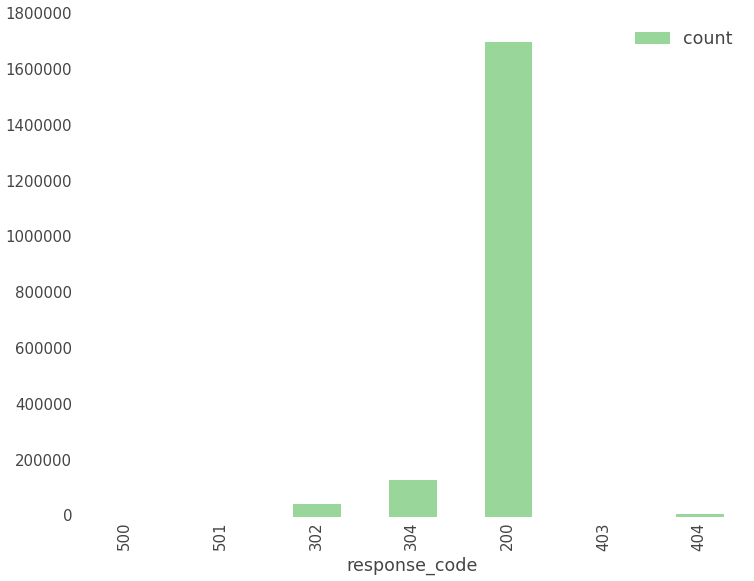

In [47]:
response_df.set_index('response_code').plot(kind='bar')

In [14]:
grouped_endpoints = logsDF.groupBy('endpoint').count()

In [15]:
grouped_endpoints = grouped_endpoints.toPandas()

#### Top endpoints

In [18]:
grouped_endpoints.sort('count', ascending= False).head(50)

,endpoint,count
16131,/images/NASA-logosmall.gif,111331
14539,/images/KSC-logosmall.gif,89639
12037,/images/MOSAIC-logosmall.gif,60468
10327,/images/USA-logosmall.gif,60014
10294,/images/WORLD-logosmall.gif,59489
544,/images/ksclogo-medium.gif,58802
2950,/images/launch-logo.gif,40871
10694,/shuttle/countdown/,40279
20919,/ksc.html,40226
7844,/images/ksclogosmall.gif,33585


#### Frequent hosts

In [20]:
grouped_hosts = logsDF.groupBy('host').count()

In [21]:
grouped_hosts = grouped_hosts.toPandas()

In [22]:
grouped_hosts.sort('count', ascending= False).head(50)

,host,count
35714,piweba3y.prodigy.com,17572
25478,piweba4y.prodigy.com,11591
56241,piweba1y.prodigy.com,9868
2687,alyssa.prodigy.com,7852
25775,siltb10.orl.mmc.com,7573
46379,piweba2y.prodigy.com,5922
5049,edams.ksc.nasa.gov,5434
6302,163.206.89.4,4906
27931,news.ti.com,4863
5194,disarray.demon.co.uk,4353


#### Most frequent user ID's and client ID's

In [27]:
grouped_uid = logsDF.groupBy('client_identd').count()

In [28]:
grouped_uid = grouped_uid.toPandas()

In [29]:
grouped_uid.sort('count', ascending= False).head(50)

,client_identd,count
0,-,1890866


#### Most frequent methods

In [30]:
grouped_method = logsDF.groupBy('method').count().toPandas()

In [33]:
grouped_method.head(3)

,method,count
0,GET,1886805
1,HEAD,3950
2,POST,111


#### Which webpages consumes more bandwidth?

In [34]:
group_content_perpage = logsDF.groupBy('endpoint').agg({'content_size': 'mean'}).toPandas()

In [37]:
group_content_perpage.sort('AVG(content_size)', ascending= False).head(50)

,endpoint,AVG(content_size)
1317,/mdss/ped/acs/SDP.ps,2854989.000000
2417,/statistics/1995/Jul/Jul95_reverse_domains.html,1118607.857143
2777,/statistics/1995/Jun/Jun95_reverse_domains.html,1082673.800000
1053,/shuttle/missions/sts-70/movies/sts-70-launch-...,929196.000000
17528,/shuttle/missions/sts-53/movies/sts-53-launch.mpg,905013.617021
3456,/shuttle/countdown/lps/sts-71-s-5-i.mpg,887988.000000
954,/shuttle/missions/sts-26/movies/sts-26-launch.mpg,877436.166667
1452,/shuttle/missions/sts-67/sounds/PariseRA.wav,861740.000000
4497,/shuttle/missions/sts-70/movies/sts-70-landing...,837457.652542
15717,/shuttle/missions/sts-70/movies/sts-70-launch-...,837088.321429


#### Creating time-based features

In [6]:
logsDF = sqlContext.read.parquet('logs_DataFrame/')

In [7]:
logsDF.show(5)

+-------------+------------+--------------------+--------------------+-------------------+------+--------+-------------+-------+
|client_identd|content_size|           date_time|            endpoint|               host|method|protocol|response_code|user_id|
+-------------+------------+--------------------+--------------------+-------------------+------+--------+-------------+-------+
|            -|         752|1995-07-13 08:51:...| /htbin/cdt_clock.pl|wynns-pc.jhuapl.edu|   GET|HTTP/1.0|          200|      -|
|            -|           0|1995-07-13 08:51:...|/shuttle/countdow...|  ftmfl-12.gate.net|   GET|HTTP/1.0|          304|      -|
|            -|          85|1995-07-13 08:51:...|/cgi-bin/imagemap...|       163.205.85.3|   GET|HTTP/1.0|          302|      -|
|            -|        1404|1995-07-13 08:51:...|/shuttle/missions...|      193.74.92.106|   GET|HTTP/1.0|          200|      -|
|            -|        3585|1995-07-13 08:51:...|  /htbin/cdt_main.pl|       163.205.85.3|   GET|

In [8]:
logsDF.printSchema()

root
 |-- client_identd: string (nullable = true)
 |-- content_size: long (nullable = true)
 |-- date_time: timestamp (nullable = true)
 |-- endpoint: string (nullable = true)
 |-- host: string (nullable = true)
 |-- method: string (nullable = true)
 |-- protocol: string (nullable = true)
 |-- response_code: long (nullable = true)
 |-- user_id: string (nullable = true)



In [9]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

In [10]:
day = udf(lambda date_time: date_time.day, IntegerType())
month = udf(lambda date_time: date_time.month, IntegerType())
hour = udf(lambda date_time: date_time.hour, IntegerType())
minute = udf(lambda date_time: date_time.minute, IntegerType())

In [11]:
logsDF_with_time = (logsDF.withColumn('day', day(logsDF.date_time))     
                        .withColumn('month', month(logsDF.date_time))    
                        .withColumn('hour', hour(logsDF.date_time))                   
                        .withColumn('minute', minute(logsDF.date_time)))             

In [12]:
logsDF_with_time.printSchema()

root
 |-- client_identd: string (nullable = true)
 |-- content_size: long (nullable = true)
 |-- date_time: timestamp (nullable = true)
 |-- endpoint: string (nullable = true)
 |-- host: string (nullable = true)
 |-- method: string (nullable = true)
 |-- protocol: string (nullable = true)
 |-- response_code: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- minute: integer (nullable = true)



In [13]:
logsDF_with_time.cache()

DataFrame[client_identd: string, content_size: bigint, date_time: timestamp, endpoint: string, host: string, method: string, protocol: string, response_code: bigint, user_id: string, day: int, month: int, hour: int, minute: int]

In [23]:
# Save to disk
logsDF_with_time.show(5)

+-------------+------------+--------------------+--------------------+-------------------+------+--------+-------------+-------+---+-----+----+------+
|client_identd|content_size|           date_time|            endpoint|               host|method|protocol|response_code|user_id|day|month|hour|minute|
+-------------+------------+--------------------+--------------------+-------------------+------+--------+-------------+-------+---+-----+----+------+
|            -|         752|1995-07-13 08:51:...| /htbin/cdt_clock.pl|wynns-pc.jhuapl.edu|   GET|HTTP/1.0|          200|      -| 13|    7|   8|    51|
|            -|           0|1995-07-13 08:51:...|/shuttle/countdow...|  ftmfl-12.gate.net|   GET|HTTP/1.0|          304|      -| 13|    7|   8|    51|
|            -|          85|1995-07-13 08:51:...|/cgi-bin/imagemap...|       163.205.85.3|   GET|HTTP/1.0|          302|      -| 13|    7|   8|    51|
|            -|        1404|1995-07-13 08:51:...|/shuttle/missions...|      193.74.92.106|   G

#### Connection attempts per hour

The whole dataset is too large to fit on a small machine, so we are going to limit our analysis to a subset of the orignal data for 8-10 days.

In [80]:
#logsDF_subset = logsDF_with_time[(logsDF_with_time.day > 3) & (logsDF_with_time.day < 28)]
# I increased the VM memory, it seems to work with the full dataset.

In [85]:
logsDF_with_time.cache()

DataFrame[client_identd: string, content_size: bigint, date_time: timestamp, endpoint: string, host: string, method: string, protocol: string, response_code: bigint, user_id: string, day: int, month: int, hour: int, minute: int]

In [86]:
grouped_hour = logsDF_with_time.groupBy('hour').count()

In [87]:
grouped_hour = grouped_hour.toPandas()

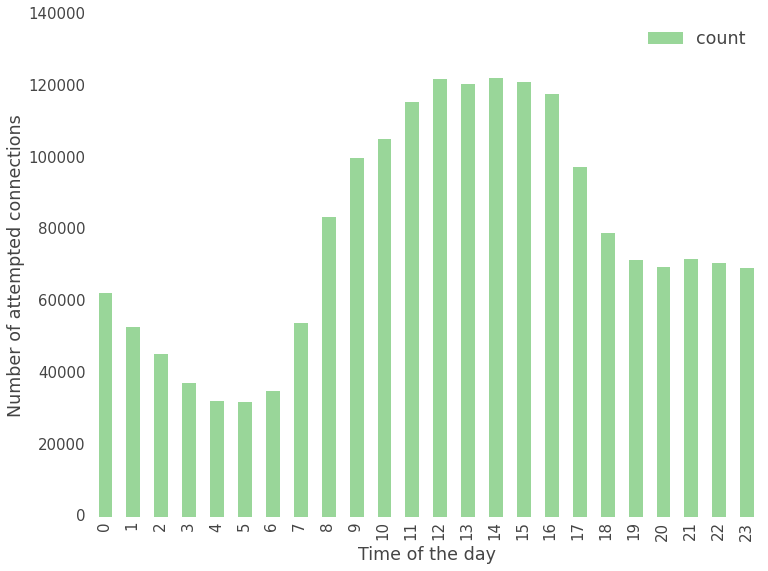

In [89]:
grouped_hour.set_index('hour').plot(kind='bar')
plt.xlabel('Time of the day')
plt.ylabel('Number of attempted connections')

We can see a dip in the traffic during the morning hours, and also a peak after the noon.

#### Connection attempts per day

In [90]:
grouped_day = logsDF_with_time.groupBy('day').count()

In [91]:
grouped_day = grouped_day.toPandas()

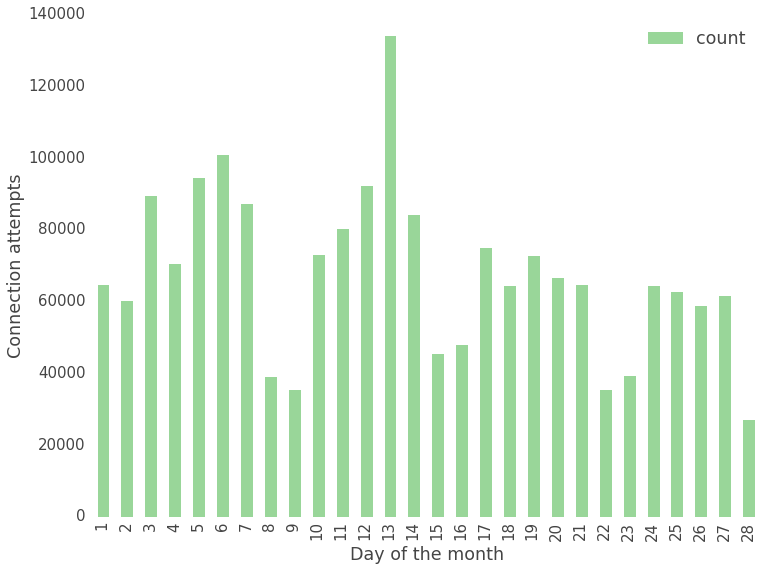

In [92]:
grouped_day.set_index('day').plot(kind='bar')
plt.xlabel('Day of the month')
plt.ylabel('Connection attempts')

In [93]:
datetime.datetime(1995,7,13).weekday()
# What happened on 13th July, 1995?

3

In [103]:
datetime.datetime(1995,7,28).weekday()

4

NASA launched a space shuttle on that day!

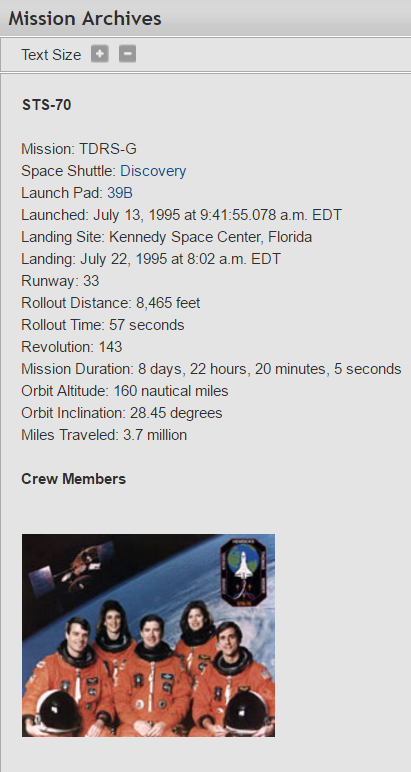

In [74]:
Image('images/nasa.PNG')

#### Connection attempts per minute

In [94]:
grouped_minute = logsDF_with_time.groupBy('minute').count()

In [95]:
grouped_minute = grouped_minute.toPandas()

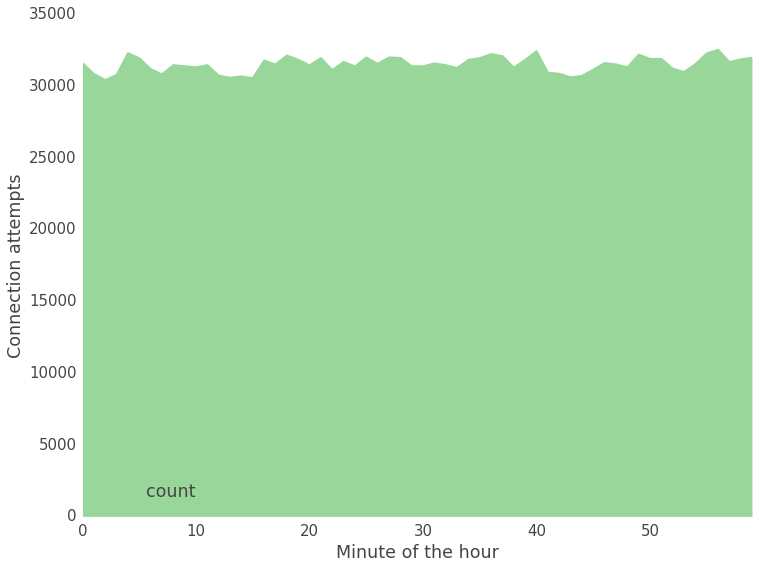

In [102]:
grouped_minute.sort('minute').set_index('minute').plot(kind='area')
plt.xlabel('Minute of the hour')
plt.ylabel('Connection attempts')
# Not much of a change really!

In [105]:
# Write data out
logsDF_with_time.write.parquet('logs_with_time_features1.parquet')